# Ajuste de Modelo usando MC
- Problema: Tenemos pocos datos experimentales como para hacer un buen ajuste de un modelo.

- Solución: Realizamos simulaciones MC de datos sintéticos para estimar: 1) valores promedio de los parámetros para del modelo y 2) los errores de dichos parámetros.

Pasos a seguir:

1) Obtenemos los datos experimentales con sus respectivos errores.

2) Hacemos un ajuste "rápido" de nuestro modelo.

3) Utilizando el ajuste anterior realizamos un número gránde N de simulaciones MC. Cada simulación consistirá en general datos sintéticos que tengan el mismo número de puntos que los datos experimentales.

4) A partir de las N simulaciones obtenemos una distribución de valores de los parámetros del modelo. De aquí podemos obtener un valor medio para cada parámetro, así como su desviación estándar.

In [1]:
# Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
# LaTeX
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

In [27]:
# Creamos unos datos "experimentales"
# No hay que hacerle mucho caso

np.random.seed(1323623)

xmin = 0.5
xmax = 3.0
n_data = 10

# Parámetros reales del modelo
# En principio estos valores no los conocemos
a_real =  1.5
b_real = -1.0

x_exp   = np.random.uniform(xmin,xmax,size=n_data)
y_real  = a_real * x_exp**b_real
s_error = 0.1/x_exp
y_exp   = y_real + np.random.normal(scale=s_error,size=np.size(y_real))

Text(0, 0.5, 'y')

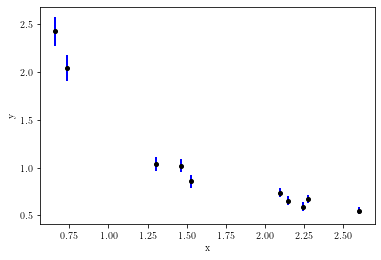

In [28]:
# Graficamos los datos experimentales
error = plt.errorbar(x_exp,y_exp,yerr=s_error,lw=0,elinewidth=2,ecolor="b",fmt='ko',markersize=4)
plt.xlabel("x")
plt.ylabel("y")

Para saber qué modelo ajustar, necesitamos un buen _prior_

- prior: cualquier cosa que me diga algo sobre lo que estoy observando

Para este ejemplo nuestro _prior_ será suponer que los datos siguen una tendencia que va como
$$
y \propto \frac{1}{x^2}
$$

Entonces el modelo que ajustaremos, siguiendo nuestro _prior_ será:

$$
y(x|a,b) = \frac{a}{x^b}
$$

In [29]:
# Utilizamos nuestro prior y ajustamos el modelo elegido
def power_law(x,a,b):
    return a*x**b

In [38]:
# El prior del prior. Qué parámetros pienso yo que se le ajusta mejor a lo que veo.
vGuess = [1.0,2.0] # Es a ojo 

# Hacemos el ajuste
vParams, aCova = optimize.curve_fit(power_law,x_exp,y_exp,vGuess)
print("Los parámetros son a = {:.3f} y b = {:.3f}".format(vParams[0],vParams[1]))

Los parámetros son a = 1.495 y b = -1.097


Text(0, 0.5, 'y')

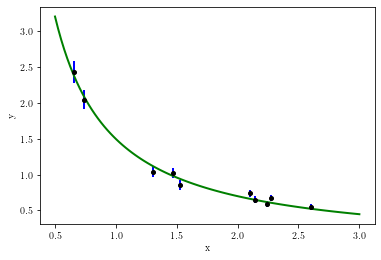

In [39]:
# Plotteamos el ajuste con los datos
x_fine = np.linspace(xmin,xmax,100)
error = plt.errorbar(x_exp,y_exp,yerr=s_error,lw=0,elinewidth=2,ecolor="b",fmt='ko',markersize=4)
fit   = plt.plot(x_fine,power_law(x_fine,*vParams),"g-",lw=2)
plt.xlabel("x")
plt.ylabel("y")

## Simulaciones MC

Debido al número tan reducido de datos experimentales, crearemos de manera aleatoria, y usando como _prior_ los parámetros del ajuste anterior, una serie de datos experimentales sintéticos, los cuales ajustaremos con el modelo, con lo cual obtenedremos una distribución de valores para los parámetros. A esto lo llamaremos simulaciones MC.

In [40]:
# Definimos el número de simulaciones MC que realizaremos

n_sim = 10000
FitParams = np.array([])

Cada experimento sintético consistirá en distribuir de manera aleatoria y uniforme los valores de $x$ (x_sim), tomaremos el ajuste anterior para crear la variable dependiente $y$ (y_gen) y, de manera aleatoria siguiendo una distribución normal, crearemos los errores "experimentales" para los nuevos datos sintéticos.

In [41]:
# Empieza el MC
for i in range(n_sim):
    x_sim = np.random.uniform(0.5,3.0,size=np.size(x_exp)) # ojo, esto es otro prior porque no tiene que ser uniforme
    y_gen = vParams[0]*x_sim**vParams[1] # Agarrar el ajuste anterior y ponerlo como prior de las simulaciones.
    y_sim = y_gen + np.random.normal(scale=s_error,size=np.size(y_gen)) # Creamos los errores sintéticos usando como media el error experimental real
    
    try:
        vsims, acova = optimize.curve_fit(power_law,x_sim,y_sim,vGuess)
    except:
        dumdum=1
        continue # Pasa al siguiente loop
        
    if np.size(FitParams) < 1:
        FitParams = np.copy(vsims)
    else:
        FitParams = np.vstack(( FitParams, vsims ))

Graficamos las distribuciones de $a$ y $b$

Para el parámetro a
Valor medio         1.494
Desviación estándar 0.050


Text(0.5, 0, 'Parámetro a')

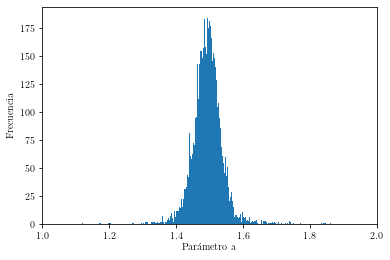

In [42]:
# Calculamos el valor medio de los parámetros a
print ("Para el parámetro a")
print ("Valor medio         {:.3f}".format(np.median(FitParams[:,0])))
print ("Desviación estándar {:.3f}".format(np.std(FitParams[:,0])))
med_a = np.median(FitParams[:,0])
std_a = np.std(FitParams[:,0])

hist_a = plt.hist(FitParams[:,0],bins=1000)
plt.xlim(1,2)
plt.ylabel("Frecuencia")
plt.xlabel("Parámetro a")

Para el parámetro b
Valor medio         -1.097
Desviación estándar  0.066


Text(0.5, 0, 'Parámetro b')

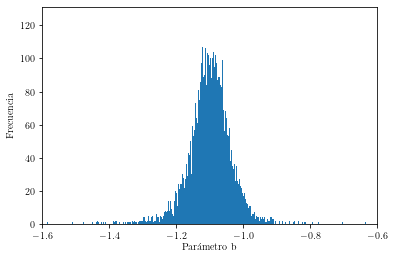

In [44]:
# Calculamos el valor medio de los parámetros b
print ("Para el parámetro b")
print ("Valor medio         {:.3f}".format(np.median(FitParams[:,1])))
print ("Desviación estándar  {:.3f}".format(np.std(FitParams[:,1])))
med_b = np.median(FitParams[:,1])
std_b = np.std(FitParams[:,1])

hist_b = plt.hist(FitParams[:,1],bins=1000)
plt.xlim(-1.6,-0.6)
plt.ylabel("Frecuencia")
plt.xlabel("Parámetro b")

Graficamos el fit promedio junto con todos los posibles valores obtenidos

(0.0, 4.0)

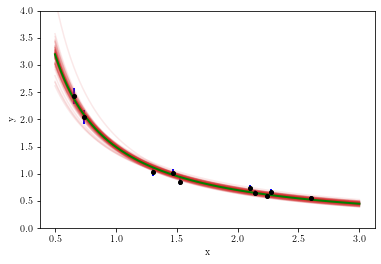

In [45]:
inds = np.random.randint(len(FitParams), size=100)

x_fine = np.linspace(xmin,xmax,100)
for ind in inds:
    params = FitParams[ind]
    plots = plt.plot(x_fine, power_law(x_fine,*params), "C3", alpha=0.1)
    
error = plt.errorbar(x_exp,y_exp,yerr=s_error,lw=0,elinewidth=2,ecolor="b",fmt='ko',markersize=4)
fit   = plt.plot(x_fine,power_law(x_fine,med_a,med_b),"g-",lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0,4)